In [2]:
# --- IMPORTATIONS ---

import os, joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.inspection import PartialDependenceDisplay

import lightgbm as lgb

In [3]:
# --- PATHS ---

MAIN_DIR = "black_box_model"
GRAPHS_DIR = os.path.join(MAIN_DIR, 'graphs')
MODEL_DIR = os.path.join(MAIN_DIR, 'model')
DATA_DIR = 'data'
os.makedirs(GRAPHS_DIR, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)

In [4]:
# --- Loading the dataset ---

data_path = os.path.join(DATA_DIR, 'dataproject2025.csv')
try:
    df = pd.read_csv(data_path)
    print("Dataset loaded successfully.")
    print("Shape of the dataset:", df.shape)
except FileNotFoundError:
    raise FileNotFoundError(f"Error: 'dataproject2025.csv' not found at {data_path}.")


Dataset loaded successfully.
Shape of the dataset: (1086236, 39)


In [5]:
# --- SAME DATA CLEARNING (MAYBE JUST DOWNLOAD CLEANED DATA) ---

# Identify columns to exclude from features
columns_to_exclude = [c for c in ['target', 'Predictions', 'Predicted probabilities', 'Unnamed: 0'] if c in df.columns]
# Drop sensitive attribute(s)
columns_to_exclude += [c for c in df.columns if 'Pct_afro_american' in c]

# The 'target' column is our dependent variable (y)
y = df['target']

# The rest of the columns are potential features (X)
X = df.drop(columns=columns_to_exclude, errors='ignore')

# Preserve the identifier column for later export if present
id_series = df['Unnamed: 0'] if 'Unnamed: 0' in df.columns else pd.Series(np.arange(len(df)), name='Unnamed: 0')

print("Features (X) shape:", X.shape)
print("Target (y) shape:", y.shape)

# Automatically identify numerical and categorical columns
numerical_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(include='object').columns.tolist()

print(f"Found {len(numerical_features)} numerical features.")
print(f"Found {len(categorical_features)} categorical features.")

# Split data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)



Features (X) shape: (1086236, 34)
Target (y) shape: (1086236,)
Found 28 numerical features.
Found 6 categorical features.


# BUILDING AND TRAINING PIPELINE

In [ ]:
# Create a preprocessing pipeline for numerical features:
# 1. Impute missing values with the median
# 2. Scale features to a standard range
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Create a preprocessing pipeline for categorical features:
# 1. Impute missing values with a constant string 'missing'
# 2. One-hot encode the categories
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False)) # sparse_output=False is often helpful for HistGradientBoostingClassifier
])

# Combine preprocessing steps into a single ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough'
)

In [ ]:
# --- FULL MODEL PIPELINE ---

# Define the model using LightGBM with explicit l2 (MSE) objective
model = lgb.LGBMRegressor(objective='l2', n_estimators=200, random_state=42)

# Create the full pipeline by chaining the preprocessor and the model
full_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                ('classifier', model)])

print("--- Full Model Pipeline ---")
print(full_pipeline)


--- Full Model Pipeline ---
Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['issue_d', 'loan duration',
                                                   'annual_inc', 'avg_cur_bal',
                                                   'bc_open_to_buy', 'bc_util',
                                                   'delinq_2yrs', 'dti',
                                                   'fico_range_high',
                                                   'funded_amnt',
                             

In [ ]:
print("Training the model...")
# The pipeline handles imputation, scaling, and encoding automatically
train_weights = np.where(y_train.values == 1, 2.0, 1.0)
full_pipeline.fit(X_train, y_train, classifier__sample_weight=train_weights)
print("Model training complete.")

Training the model...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.036633 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4006
[LightGBM] [Info] Number of data points in the train set: 868988, number of used features: 148
[LightGBM] [Info] Start training from score 0.347784
Model training complete.


In [ ]:
# --- SAVING THE PIPELINE ---

joblib.dump(full_pipeline, 'model/grad_boost_pipeline.joblib')

['model/grad_boost_pipeline.joblib']

# PARTIAL DEPENDANCE PLOT

In [6]:
full_pipeline = joblib.load('black_box_model/model/grad_boost_pipeline.joblib')

Partial dependance plot

In [58]:
n_sample = 1000 # how many instances to take into consideration (1 million is too long)

/Users/paul-philiplouis/anaconda3/envs/dynamic/lib/python3.12/site-packages/sklearn/inspection/_partial_dependence.py:717: FutureWarning: The column 0 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(
/Users/paul-philiplouis/anaconda3/envs/dynamic/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/paul-philiplouis/anaconda3/envs/dynamic/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/paul-philiplouis/anaconda3/envs/dynamic/lib/python3.12/s

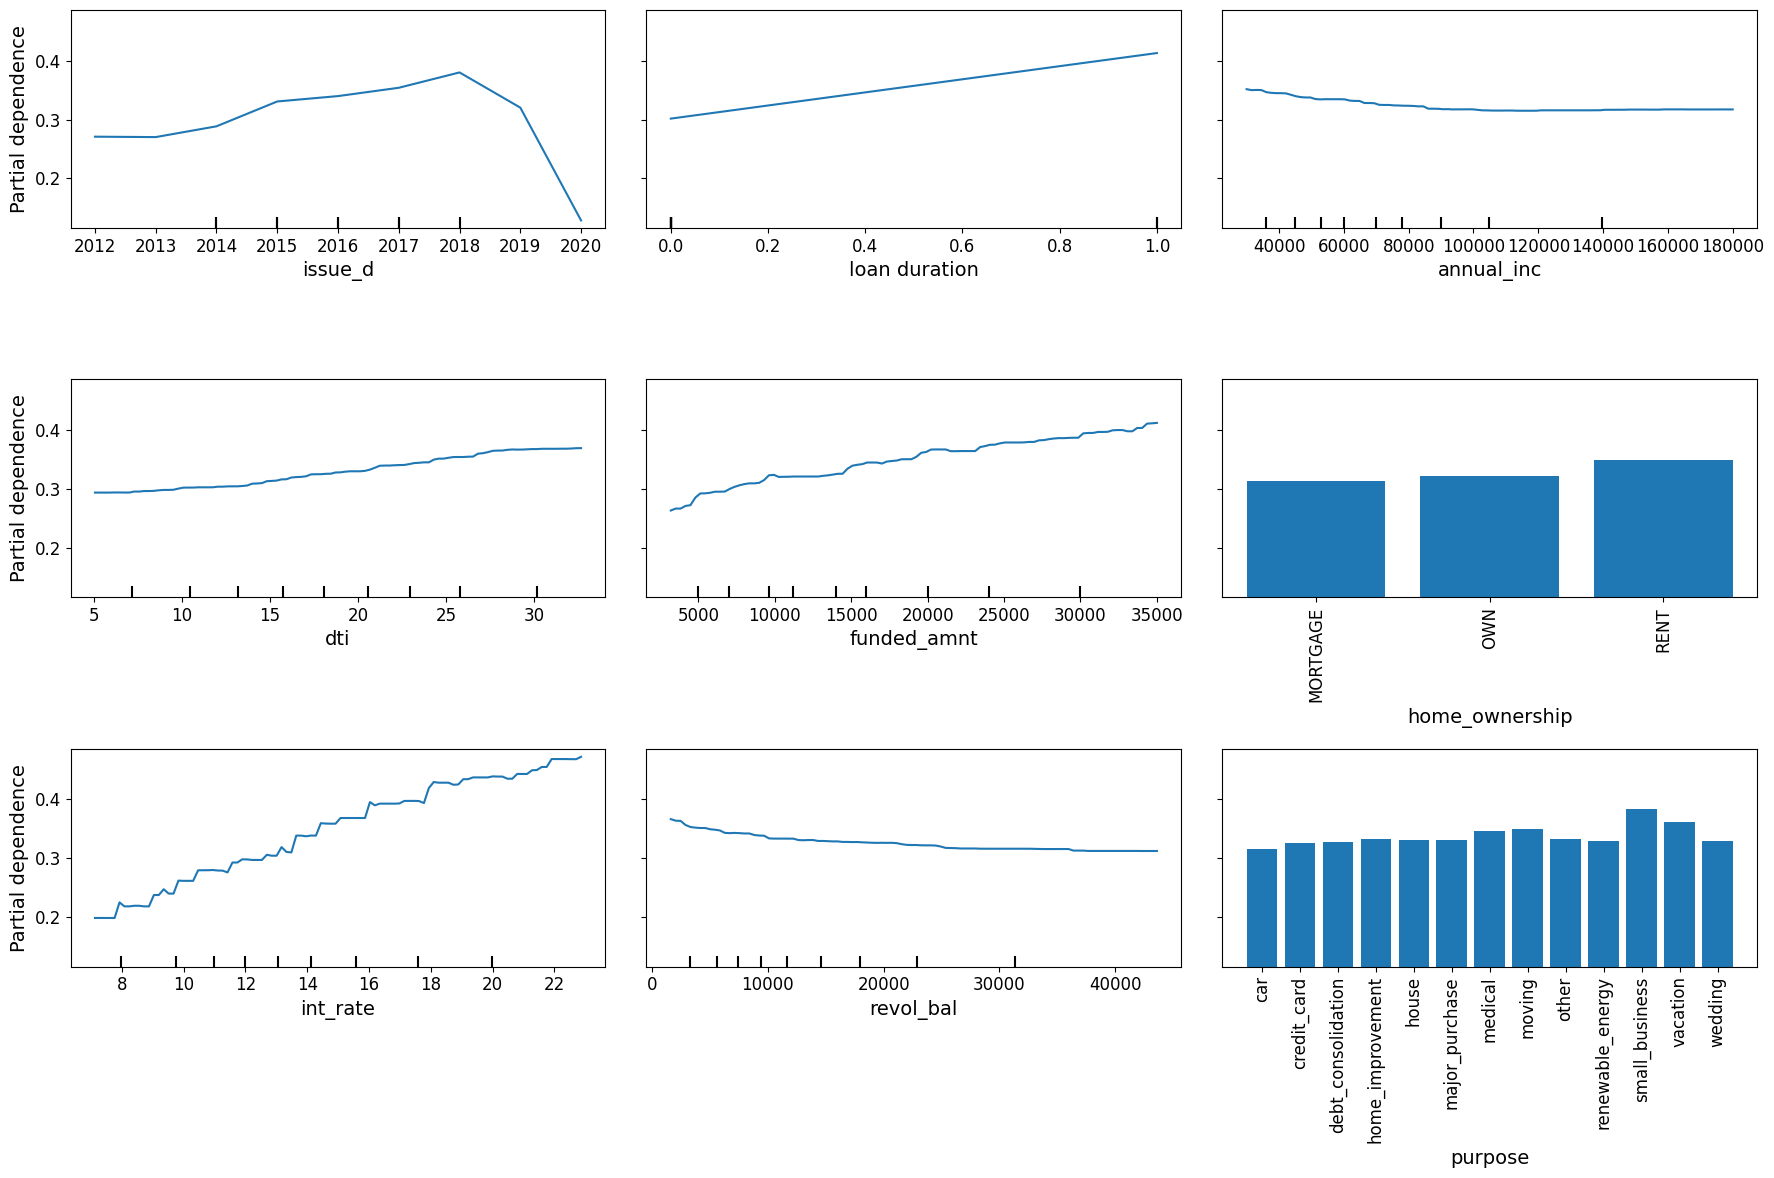

In [85]:
n_rows = 3
n_cols = 3

fig, ax = plt.subplots(
    n_rows, n_cols,
    figsize=(6 * n_cols, 4 * n_rows),   # width × height per subplot
)

#features = X_train.columns.append(pd.Index(['issue_d'])) # 35th plot because 7x5 is more readable than 17x2
significant = pd.Index(['issue_d', 'loan duration', 'annual_inc', 'dti', 'funded_amnt', 'home_ownership', 'int_rate', 'revol_bal', 'purpose'])

disp = PartialDependenceDisplay.from_estimator(
    full_pipeline,
    X_train.sample(n_sample),
    features=significant,
    categorical_features=['home_ownership', 'purpose'],
    n_cols=n_cols,    
    ax=ax,                
)

fig.tight_layout()  # add breathing room between plots


plt.rcParams['font.size'] = 14    # base size for everything
plt.rcParams['axes.titlesize'] = 18 # subplot titles
plt.rcParams['axes.labelsize'] = 14 # x/y labels
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.show()

/Users/paul-philiplouis/anaconda3/envs/dynamic/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/paul-philiplouis/anaconda3/envs/dynamic/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/paul-philiplouis/anaconda3/envs/dynamic/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/paul-philiplouis/anaconda3/envs/dynamic/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/paul-philiplouis/anaconda3/envs/dynamic/lib/python3.12/site-packages/sklearn/utils/validation

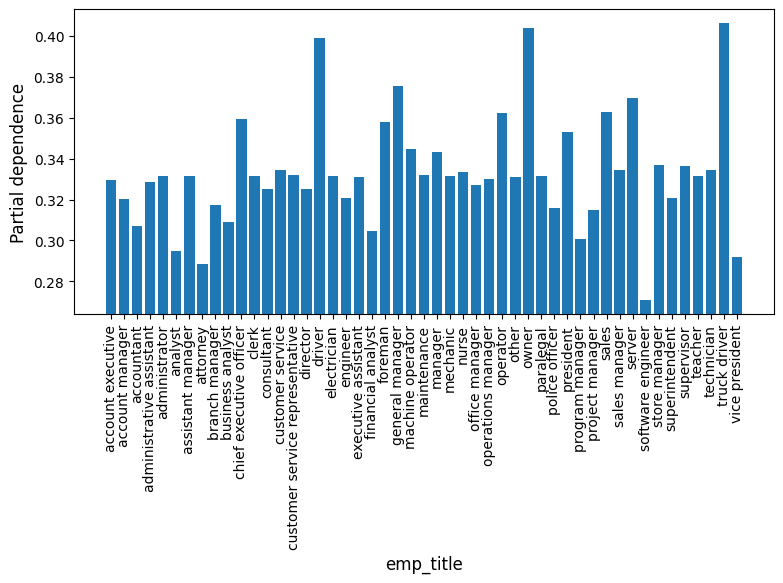

In [71]:
fig, ax = plt.subplots(figsize=(8,6))

disp = PartialDependenceDisplay.from_estimator(
    full_pipeline,
    X_train.sample(n_sample),
    features=["emp_title"],
    categorical_features=["emp_title"],
    ax=ax
)

plt.tight_layout()

plt.rcParams['font.size'] = 12     # base size for everything
plt.rcParams['axes.titlesize'] = 16 # subplot titles
plt.rcParams['axes.labelsize'] = 12 # x/y labels
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10

plt.show()

/Users/paul-philiplouis/anaconda3/envs/dynamic/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/paul-philiplouis/anaconda3/envs/dynamic/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/paul-philiplouis/anaconda3/envs/dynamic/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/paul-philiplouis/anaconda3/envs/dynamic/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/paul-philiplouis/anaconda3/envs/dynamic/lib/python3.12/site-packages/sklearn/utils/validation

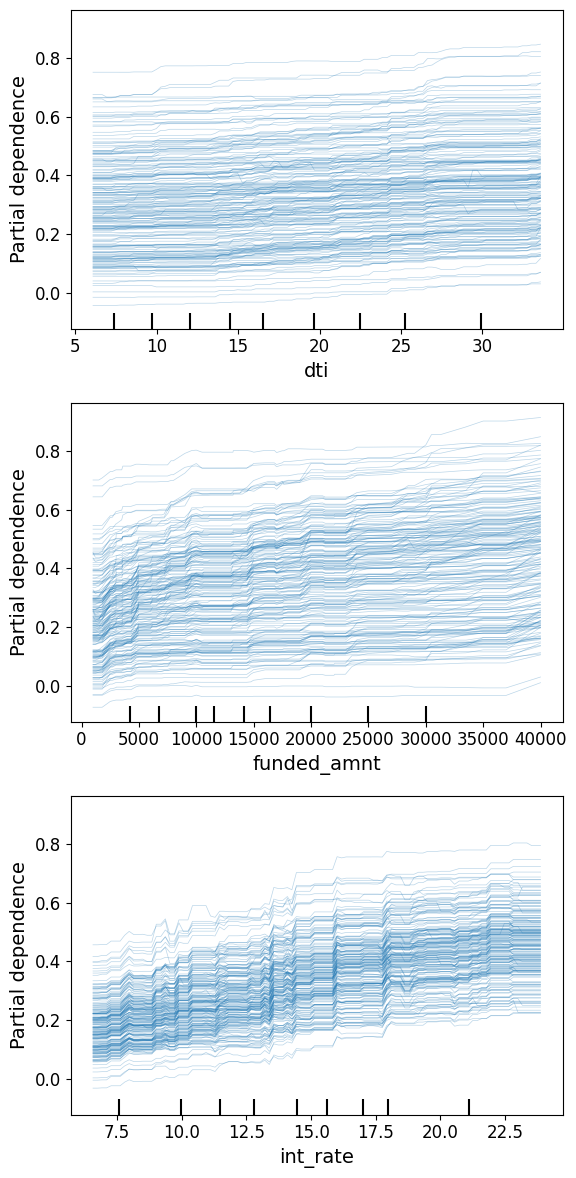

In [83]:
n_rows = 3
n_cols = 1

fig, ax = plt.subplots(
    n_rows, n_cols,
    figsize=(6 * n_cols, 4 * n_rows),   # width × height per subplot
)

PartialDependenceDisplay.from_estimator(full_pipeline, 
                                        X_train.sample(200), 
                                        features=pd.Index(["dti", "funded_amnt", "int_rate"]),
                                        kind='individual',
                                        ax=ax)


fig.tight_layout()  # add breathing room between plots


plt.rcParams['font.size'] = 14    # base size for everything
plt.rcParams['axes.titlesize'] = 18 # subplot titles
plt.rcParams['axes.labelsize'] = 14 # x/y labels
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.show()
